In [1]:
import pandas as pd
import numpy as np
import os
import sys 
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

In [2]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, ParameterGrid
import xgboost as xgb
from xgboost import plot_importance, plot_tree

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\myvenv\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: otobuf is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
abs = os.getcwd()
abs = abs.replace("\\src\\Time_series","")
sys.path.insert(0, abs   + "\\utils")

In [4]:
from time_series import split_train_test_validation
from common import process_check
from common import process_normal
from common import process_standard
from common import process_labelencode
from common import RandomizedSCV
from common import corr_mat
from common import co_mat

In [6]:
Thai_df = pd.read_csv(abs + "/dataset/Time_series/Thai_df.csv")

In [6]:
Thai_df.columns

Index(['Unnamed: 0', 'week', 'category', 'city_code', 'checkout_price',
       'base_price', 'emailer_for_promotion', 'homepage_featured',
       'num_orders', 'op_area'],
      dtype='object')

In [7]:
Thai_df.drop(columns = ['Unnamed: 0'], inplace = True)

In [8]:
Thai_df.category.unique()

array(['Beverages', 'Starters', 'Extras', 'Other Snacks', 'Soup'],
      dtype=object)

In [9]:
Thai_df.city_code.unique()

array([647, 614, 679, 659, 526, 590, 599, 685, 461, 649, 541, 478, 703,
       576, 628, 702, 579, 596, 648, 632, 522, 615, 577, 517, 651, 683,
       713, 609, 675, 553, 593, 654, 693, 658, 515, 556, 561, 680, 620,
       638, 700, 676, 604, 456, 562, 695, 699, 602, 485, 698, 473],
      dtype=int64)

In [10]:
Thai_df.emailer_for_promotion.unique()

array([0, 1], dtype=int64)

In [11]:
Thai_df.homepage_featured.unique()

array([0, 1], dtype=int64)

In [12]:
df = Thai_df[['week', 'category', 'city_code', 'checkout_price', 'base_price', 'emailer_for_promotion', 'homepage_featured', 'num_orders', 'op_area']]

In [13]:
df.category, thai_category_lab = process_labelencode(df, "category", True)
df.city_code, thai_city_code_lab = process_labelencode(df, "city_code", True)

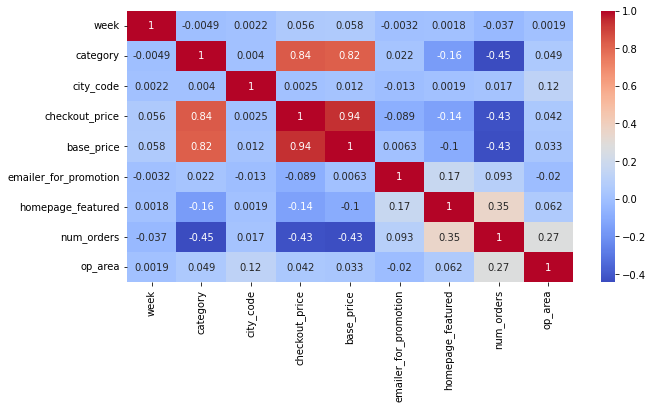

In [14]:
corr_mat(df)

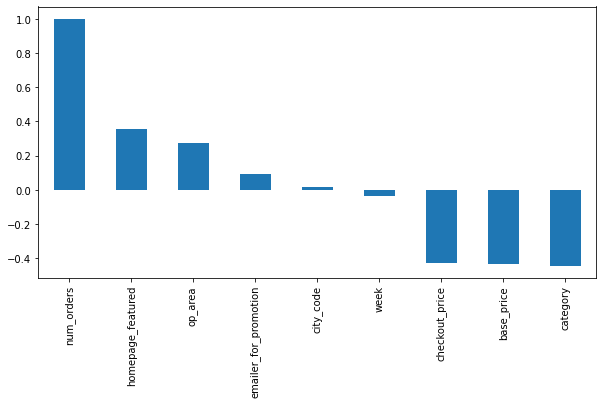

In [15]:
co_mat(df, 'num_orders')

In [16]:
df.corr()['num_orders'].abs().sort_values(ascending=False)

num_orders               1.000000
category                 0.445066
base_price               0.434476
checkout_price           0.425253
homepage_featured        0.353255
op_area                  0.274784
emailer_for_promotion    0.093137
week                     0.037383
city_code                0.016620
Name: num_orders, dtype: float64

In [17]:
sca, norm = process_check(df)
print(sca, norm)

['week', 'category', 'city_code', 'checkout_price', 'base_price'] ['emailer_for_promotion', 'homepage_featured', 'num_orders', 'op_area']


In [18]:
sca = ['week', 'checkout_price', 'base_price']
norm = ['op_area']
df[sca], stand_thai = process_standard(df, sca)
df[norm], normal_thai = process_normal(df, norm)
norm = ['num_orders']
df[norm], normal_thai_num = process_normal(df, norm)

In [19]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test_validation(df, 0.2, 0.1, 'num_orders')

c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\ML_framework\utils\time_series.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = train.drop([label], 1)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\ML_framework\utils\time_series.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_valid = valid.drop([label], 1)
c:\Users\abulf\Documents\Python_tutorial\Assignments\Machine_learning\ML_framework\utils\time_series.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test  = test.drop([label], 1)


In [20]:
parameters = {
    'n_estimators': [350, 400],
    'learning_rate': [0.05, 0.001],
    'max_depth': [10, 11, 12],
    'gamma': [0.01, 0.1]
}

param_size = ParameterGrid(parameters)
len(param_size)

24

In [21]:
eval_set = [(X_train, y_train), (X_valid, y_valid)]
gpu_dict = {
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist',
    'eval_set': 'eval_set',
     'verbose': False,
     
}

In [22]:
%%time
model = xgb.XGBRegressor(**gpu_dict)
random_result = RandomizedSCV(model,parameters,1, -1, len(param_size)-4, X_train, y_train)

print('Best Score: ', random_result.best_score_*100)
print('Best Params: ', random_result.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[20:27:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "eval_set", "verbose" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Best Score:  46.9330950966315
Best Params:  {'n_estimators': 400, 'max_depth': 11, 'learning_rate': 0.05, 'gamma': 0.1}
CPU times: total: 2.77 s
Wall time: 3min 47s


In [23]:
%%time

model = xgb.XGBRegressor(**random_result.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: total: 2min 13s
Wall time: 20.8 s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0.1, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=400, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [24]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)}')
print(f'y_pred = {y_pred}')

y_true = [0.001507   0.00312164 0.00010764 ... 0.00301399 0.00312164 0.01184069]
y_pred = [0.00942663 0.00942663 0.00927706 ... 0.01690416 0.02045645 0.01690416]


In [25]:
score = model.score(X_test,y_test)
score

0.45070578103407777

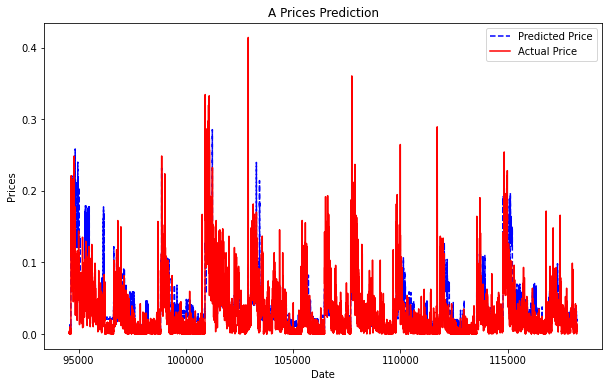

In [26]:
test_set_range = y_test.index
plt.plot(test_set_range, y_pred, color='blue', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, y_test, color='red', label='Actual Price')
plt.title('A Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

Beverages, 647, 136.83, 152.29, 0, 0, 2

In [27]:
week = int(input("Weeks: ")) + 145
category = (input("Category: "))
city_code = int(input("City Code: "))
checkout_price = float(input("Checkout Price: "))
base_price = float(input("Base Price: "))
emailer_for_promotion = int(input("Emailer for Promotion: "))
homepage_featured = int(input("Homepage Featured: "))
op_area = float(input("Operational Area: "))

In [28]:
df.columns

Index(['week', 'category', 'city_code', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'op_area'],
      dtype='object')

In [29]:
cat_lst = []
cat_lst.append(category)
city_code_lst = []
city_code_lst.append(city_code)

category = thai_category_lab.transform(cat_lst)
city_code = thai_city_code_lab.transform(city_code_lst)

print(category,city_code)
print(city_code[0])
print(category[0])

[0] [30]
30
0


In [30]:
sca = []
sca.append(week)
sca.append(checkout_price)
sca.append(base_price)
sca = np.reshape(sca, (-1,3 ))

sca1 = stand_thai.transform(sca)
sca1

array([[ 1.72833143, -1.1122625 , -1.04471885]])

In [31]:
nor = []
#nor.append(checkout_price)
#nor.append(base_price)
nor.append(op_area)
nor = np.reshape(nor, (-1,1 ))

nor1 = normal_thai.transform(nor)
nor1

array([[0.18032787]])

In [32]:
main_lst = []
main_lst.append(sca1[0][0])
main_lst.append(category[0])
main_lst.append(city_code[0])
main_lst.append(sca1[0][1])
main_lst.append(sca1[0][2])
main_lst.append(emailer_for_promotion)
main_lst.append(homepage_featured)
main_lst.append(nor1[0][0])
main_lst

[1.7283314283800515,
 0,
 30,
 -1.1122625012809833,
 -1.0447188472487634,
 0,
 0,
 0.18032786885245902]

In [33]:
main_lst = np.reshape(main_lst, (-1,8 ))
pred = model.predict(main_lst)
pred = np.reshape(pred, (-1,1 ))
pred = normal_thai_num.inverse_transform(pred)
pred[0][0]

191.45276

In [34]:
pickle.dump(model, open(abs + "\\output\\Time Series\\Thai\\model.pkl", 'wb'))
pickle.dump(thai_category_lab, open(abs + "\\output\\Time Series\\Thai\\thai_category_lab.pkl", 'wb'))
pickle.dump(thai_city_code_lab, open(abs + "\\output\\Time Series\\Thai\\thai_city_code_lab.pkl", 'wb'))
pickle.dump(stand_thai, open(abs + "\\output\\Time Series\\Thai\\stand_thai.pkl", 'wb'))
pickle.dump(normal_thai, open(abs + "\\output\\Time Series\\Thai\\normal_thai.pkl", 'wb'))
pickle.dump(normal_thai_num, open(abs + "\\output\\Time Series\\Thai\\normal_thai_num.pkl", 'wb'))